# Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

nltk.download('punkt')
nltk.download('stopwords')

import warnings  #Hide Warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
#Show text full width
pd.set_option('display.max_colwidth', None)
%pprint

Pretty printing has been turned OFF


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AliiPmD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AliiPmD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head(5)

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [3]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head(5)

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## EDA

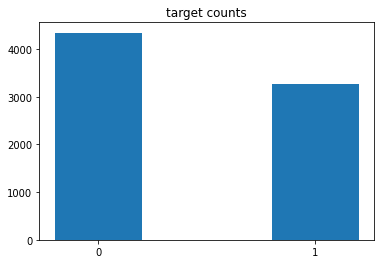

In [4]:
plt.hist(train.target, bins=[-.2,.2,0.8,1.2])
plt.xticks((0,1))
plt.title("target counts")
plt.show()

In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

#### Check number of unique locations:

In [7]:
print("location unique elements in train: ",train['location'].nunique())
print("location unique elements in test: ",test['location'].nunique())

location unique elements in train:  3341
location unique elements in test:  1602


In [8]:
list(set(train['location']) - set(test['location']))[:20]

['Canadian bread', 'Five down from the Coffeeshop', 'Peterborough, Ontario, Canada', '(he/him)', 'WAISTDEEP, TX', '107-18 79TH STREET', 'on to the next adventure', 'East TN.', 'New Delhi, India', 'Sale, England', 'Wakefield MA', 'Terre Haute, IN', 'www.aprylpooley.com', 'Charlotte, N.C.', 'Homs- Syria', 'The Circle of Life', 'West Richland, WA', 'sri lanka', 'I O W A', 'New Mexico, USA']

##### there is a lot of trash data in 'location' column :)  so i think it's better to just drop it

#### Check number of unique keywords and wheter they are same for both datasets:

In [9]:
print("Keyword unique elements in train: ",train['keyword'].nunique())
print("Keyword unique elements in test: ",test['keyword'].nunique())

Keyword unique elements in train:  221
Keyword unique elements in test:  221


In [10]:
list(set(train['keyword']) - set(test['keyword']))[:20]

[]

#### Check most frequent keywords per target:

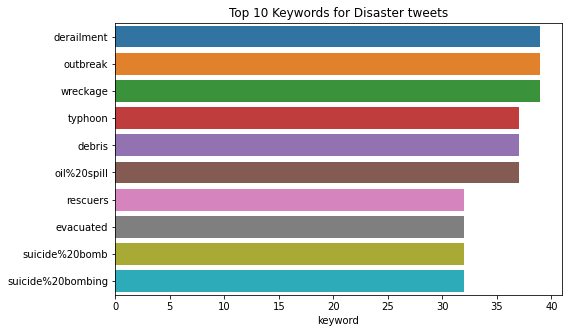

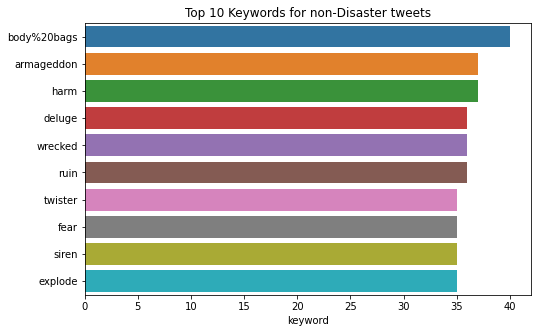

In [11]:
keyword_disaster =(train[train.target ==1]['keyword'].value_counts()).sort_values(ascending=False)[:10]
keyword_non_disaster =(train[train.target ==0]['keyword'].value_counts()).sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
sns.barplot(x=keyword_disaster , y=keyword_disaster.index)
plt.title("Top 10 Keywords for Disaster tweets")
plt.show()
plt.figure(figsize=(8,5))
sns.barplot(x=keyword_non_disaster , y=keyword_non_disaster.index)
plt.title("Top 10 Keywords for non-Disaster tweets")
plt.show()

In [12]:
def histPlot(featureName,title,barQTY=5):
    plt.figure(figsize=(8,5))
    qty = int((np.max(allData[featureName]) - np.min(allData[featureName]))/barQTY)
    bins = np.linspace(np.min(allData[featureName]), np.max(allData[featureName]),qty)
    plt.hist(allData[allData['target']==0][featureName],bins=bins,color='red',rwidth=0.5,alpha = 0.5,label='0')
    plt.hist(allData[allData['target']==1][featureName],bins=bins,color='blue',rwidth=0.5,alpha = 0.5,label='1')
    plt.title(title)
    plt.legend()
    plt.show()

### Lets Clean data a little 

#### As you gonna see, There is some repetitive tweets with different targets that is harmful for model, so we gonna drop them
##### Also there are more of repetitive and similar tweets and i gonna find and drop them in following after some preprocesses on tweets...

In [13]:
train.text.str.lower().duplicated().sum()

111

In [14]:
duplicatdDF = train[train.text.str.lower().duplicated()].sort_values(by='text')
duplicatdDF.head(20)

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
2828,4064,displaced,NaN,#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,1
2841,4086,displaced,Pedophile hunting ground,#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,1
1725,2488,collided,"Peterborough, Ont.",#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,1


In [15]:
train.drop(duplicatdDF.index , axis=0, inplace=True)
train.shape

(7502, 5)

#### Concat train and test data to make some changes on them togheder

In [16]:
allData = pd.concat([train,test])
allData.shape

(10765, 5)

### Lets extract some features:
- ##### Lenght of tweets
- ##### Count of words in tweets
- ##### Count of numbers in tweets
- ##### Count of sentenses in tweets
- ##### Count of hashtags in tweets
- ##### Text of hashtags
- ##### Count of mentions in tweets
- ##### Text of Mentions
- ##### Count of links in tweets
- ##### Word per lenght of tweet
- ##### Punctuation count per tweet lenght
- ##### Uppercase letters count per tweet lenght
- ##### MinMaxScaling for numeric columns

In [17]:
allData['len'] = allData.text.apply(lambda x : len(x))
print("max len of tweets: ", np.max(allData['len']))
print("min len of tweets: ", np.min(allData['len']))

max len of tweets:  157
min len of tweets:  5


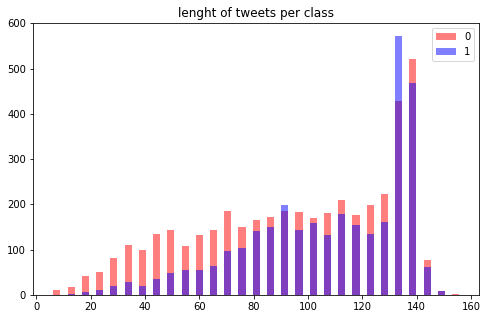

In [18]:
histPlot('len','lenght of tweets per class')

In [19]:
allData['words'] = allData.text.apply(lambda x: len(nltk.word_tokenize(x)))
print("max: ", np.max(allData['words']))
print("min: ", np.min(allData['words']))

max:  72
min:  1


In [20]:
allData[allData['words']==1]

,id,keyword,location,text,target,len,words
24,36,NaN,NaN,LOOOOOOL,0.0,8,1
1882,2703,crushed,NaN,Crushed,0.0,7,1
3670,5224,fatality,Rafael castillo,fatality,0.0,8,1
4971,7088,meltdown,NaN,Meltdown,0.0,8,1
5115,7295,nuclear%20reactor,NaN,Err:509,0.0,7,1
5184,7400,obliterated,New York,Obliterated,0.0,11,1
780,2577,crash,PPCC,Crash,NaN,5,1
1242,4074,displaced,NaN,Displaced,NaN,9,1
1824,6168,hijack,#HDYNATION,hijack,NaN,6,1


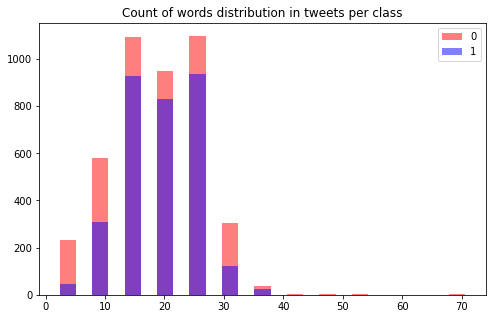

In [21]:
histPlot('words',"Count of words distribution in tweets per class")

In [22]:
allData['numbers'] = allData.text.apply(lambda x : len(re.findall( r'\d+,*\d+|\d+' , x)))
print("max: ", np.max(allData['numbers']))
print("min: ", np.min(allData['numbers']))

max:  20
min:  0


In [23]:
allData[allData['numbers']==20].text

3050    #Earthquake #Sismo M 1.9 - 15km E of Anchorage Alaska: Time2015-08-06 00:11:16 UTC2015-08-05 16:11:16 -08:00 ... http://t.co/Z0VeR1hVM9
Name: text, dtype: object

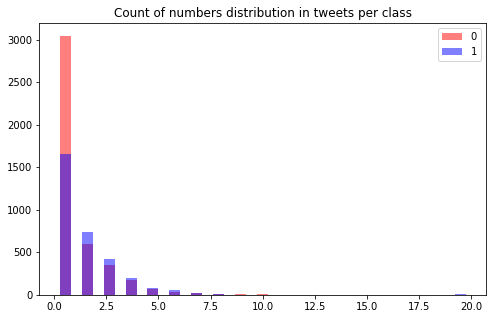

In [24]:
histPlot('numbers','Count of numbers distribution in tweets per class',1)

In [25]:
allData['sent'] = allData.text.apply(lambda x: len(nltk.sent_tokenize(x)))
print("max: ", np.max(allData['sent']))
print("min: ", np.min(allData['sent']))

max:  12
min:  1


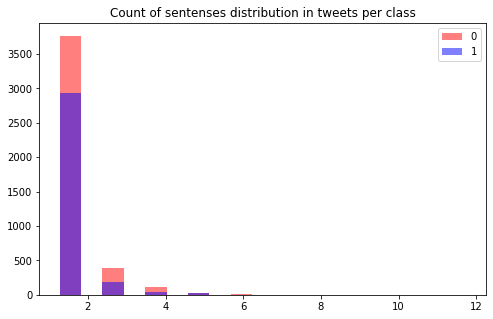

In [26]:
histPlot('sent','Count of sentenses distribution in tweets per class',1)

In [27]:
allData['hashtags'] = allData.text.apply(lambda x : len(re.findall( r'#' , x)))
print("max: ", np.max(allData['hashtags']))
print("min: ", np.min(allData['hashtags']))

max:  13
min:  0


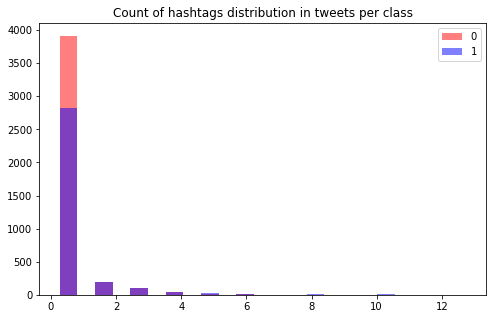

In [28]:
histPlot('hashtags','Count of hashtags distribution in tweets per class',1)

In [29]:
# extract hashtags
allData['tags']=allData.text.str.lower().apply(lambda x: " ".join([i for i in re.findall(r'#([A-Za-z]+)',x)]))
allData.head(2)
# We'll apply tf-idf on this col

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,69,14,0,1,1,earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,8,0,2,0,


In [30]:
allData['mentions'] = allData.text.apply(lambda x : len(re.findall( r'@' , x)))
print("max: ", np.max(allData['mentions']))
print("min: ", np.min(allData['mentions']))

max:  10
min:  0


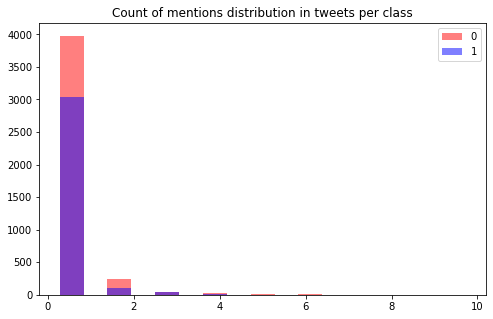

In [31]:
histPlot('mentions','Count of mentions distribution in tweets per class',1)

In [32]:
#test regex
re.findall(r'@([A-Za-z0-9_.]+)',"@kjk_kj @adas21ea @asdasd.aew3_w @ aats")

['kjk_kj', 'adas21ea', 'asdasd.aew3_w']

In [33]:
# extract mentions
allData['mentionText']=allData.text.str.lower().apply(lambda x: " ".join([i for i in re.findall(r'@([A-Za-z0-9_.]+)',x)]))
allData.tail(2)
# We'll apply tf-idf on this col

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,65,11,3,1,0,,0,
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,NaN,68,11,0,2,2,cityofcalgary yycstorm,0,


In [34]:
allData['links'] = allData.text.apply(lambda x : len(re.findall( r'http' , x)))
print("max: ", np.max(allData['links']))
print("min: ", np.min(allData['links']))

max:  4
min:  0


In [35]:
allData[allData['links']==4]

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0.0,114,18,5,1,1,nsfw,0,,4
7082,10143,upheaval,Attock,Ancient Mayan Tablet found via http://t.co/LmUMzkLtln http://t.co/yebxxAryBF http://t.co/SRRUqfffr6 http://t.co/CadzxAgMSI,0.0,122,17,1,1,0,,0,,4
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,NaN,114,18,5,1,1,nsfw,0,,4


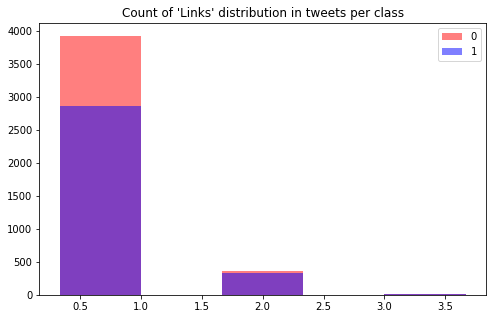

In [36]:
histPlot('links','Count of \'Links\' distribution in tweets per class',1)

In [37]:
# word per lenght of tweet
allData['density'] = allData.words / allData.len
allData.head(1)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,69,14,0,1,1,earthquake,0,,0,0.202899


In [38]:
# Punctuation count per tweet lenght
allData['punctuation'] = allData.text.apply(lambda x : len(re.findall( r'[^A-Za-z0-9\s]' , x))/len(x) )

In [39]:
# Uppercase letters count per tweet lenght
allData['upper'] = allData.text.apply(lambda x : len(re.findall( r'[A-Z]' , x))/len(x))

<AxesSubplot:>

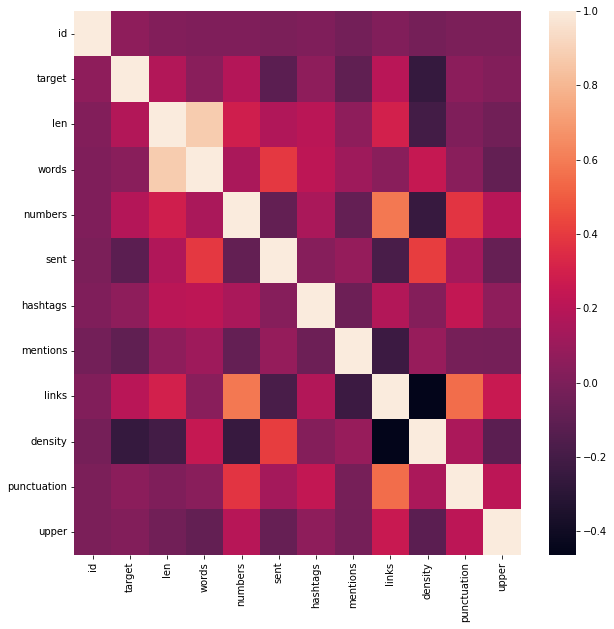

In [40]:
#heatmap
plt.figure(figsize=(10,10))
sns.heatmap(allData.corr())

#### Scaling columns:

In [41]:
scaler = MinMaxScaler()
allData[['len','words','numbers','sent','hashtags','mentions','links']] = scaler.fit_transform(
                allData[['len','words','numbers','sent','hashtags','mentions','links']])
allData.head(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,0.421053,0.183099,0.0,0.000000,0.076923,earthquake,0.0,,0.0,0.202899,0.014493,0.144928
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,0.217105,0.098592,0.0,0.090909,0.000000,,0.0,,0.0,0.210526,0.026316,0.131579


### Lets process tweets:
- ##### Lowercase tweets
- ##### Remove URLs
- ##### Remove Punctuation
- ##### Remove Short words <=2 chars
- ##### Remove Stopwords
- ##### Lemmatization
- ##### GetDummy for keyword column
- ##### TF-IDF on tweets
- ##### TF-IDF on tags
- ##### TF-IDF on mentions

In [42]:
#lower Case:
allData['tweet'] = allData.text.apply(lambda x: x.lower())
allData.head(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,0.421053,0.183099,0.0,0.000000,0.076923,earthquake,0.0,,0.0,0.202899,0.014493,0.144928,our deeds are the reason of this #earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,0.217105,0.098592,0.0,0.090909,0.000000,,0.0,,0.0,0.210526,0.026316,0.131579,forest fire near la ronge sask. canada


In [43]:
#Remove urls:
allData['tweet'] = allData['tweet'].str.replace(r'http[^\s]+'," ")
allData.tail(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,0.394737,0.140845,0.15,0.000000,0.000000,,0.0,,0.25,0.169231,0.107692,0.230769,meg issues hazardous weather outlook (hwo)
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,NaN,0.414474,0.140845,0.00,0.090909,0.153846,cityofcalgary yycstorm,0.0,,0.00,0.161765,0.044118,0.073529,#cityofcalgary has activated its municipal emergency plan. #yycstorm


In [44]:
# Remove Punctuation
allData['tweet'] = allData['tweet'].str.replace(r'[^A-Za-z0-9\s]',"")
allData.tail(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,0.394737,0.140845,0.15,0.000000,0.000000,,0.0,,0.25,0.169231,0.107692,0.230769,meg issues hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,NaN,0.414474,0.140845,0.00,0.090909,0.153846,cityofcalgary yycstorm,0.0,,0.00,0.161765,0.044118,0.073529,cityofcalgary has activated its municipal emergency plan yycstorm


In [45]:
#Remove short words <=2 chars
allData['tweet'] = allData['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
allData.tail(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,0.394737,0.140845,0.15,0.000000,0.000000,,0.0,,0.25,0.169231,0.107692,0.230769,meg issues hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,NaN,0.414474,0.140845,0.00,0.090909,0.153846,cityofcalgary yycstorm,0.0,,0.00,0.161765,0.044118,0.073529,cityofcalgary has activated its municipal emergency plan yycstorm


In [46]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
allData['tweet'] = allData['tweet'].apply(lambda x: " ".join(
    [i for i in nltk.word_tokenize(x) if i not in stopwords]))

In [47]:
allData.tail(2)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN,0.394737,0.140845,0.15,0.000000,0.000000,,0.0,,0.25,0.169231,0.107692,0.230769,meg issues hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,NaN,0.414474,0.140845,0.00,0.090909,0.153846,cityofcalgary yycstorm,0.0,,0.00,0.161765,0.044118,0.073529,cityofcalgary activated municipal emergency plan yycstorm


In [48]:
# Lemmatization
lma = nltk.WordNetLemmatizer()
allData['tweet']=allData['tweet'].apply(lambda x: " ".join(
    [lma.lemmatize(i) for i in nltk.word_tokenize(x)]))

In [49]:
allData.head(5)

,id,keyword,location,text,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,0.421053,0.183099,0.00,0.000000,0.076923,earthquake,0.0,,0.0,0.202899,0.014493,0.144928,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,0.217105,0.098592,0.00,0.090909,0.000000,,0.0,,0.0,0.210526,0.026316,0.131579,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,0.842105,0.323944,0.00,0.090909,0.000000,,0.0,,0.0,0.180451,0.022556,0.015038,resident asked shelter place notified officer evacuation shelter place order expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,0.394737,0.112676,0.05,0.000000,0.076923,wildfires,0.0,,0.0,0.138462,0.030769,0.015385,13000 people receive wildfire evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,0.546053,0.239437,0.00,0.000000,0.153846,alaska wildfires,0.0,,0.0,0.204545,0.022727,0.034091,got sent photo ruby alaska smoke wildfire pours school


In [50]:
#get dummy for keyword column
allData = pd.concat([allData.drop('keyword',axis=1) , pd.get_dummies(allData['keyword'],dummy_na=True)], axis=1)
allData.shape

(10765, 239)

#### Separate datasets:

In [51]:
test = allData.iloc[7502:]
testIDs = test.id
test.drop(['id','target','text','location'],axis=1,inplace=True)
print(test.shape)
test.head(2)

(3263, 235)


,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,casualties,casualty,catastrophe,catastrophic,chemical%20emergency,cliff%20fall,collapse,collapsed,collide,collided,collision,crash,crashed,crush,crushed,curfew,cyclone,damage,danger,dead,death,deaths,debris,deluge,deluged,demolish,demolished,demolition,derail,derailed,derailment,desolate,desolation,destroy,destroyed,destruction,detonate,detonation,devastated,devastation,disaster,displaced,drought,drown,drowned,drowning,dust%20storm,earthquake,electrocute,electrocuted,emergency,emergency%20plan,emergency%20services,engulfed,epicentre,evacuate,evacuated,evacuation,explode,exploded,explosion,eyewitness,famine,fatal,fatalities,fatality,fear,fire,fire%20truck,first%20responders,flames,flattened,flood,flooding,floods,forest%20fire,forest%20fires,hail,hailstorm,harm,hazard,hazardous,heat%20wave,hellfire,hijack,hijacker,hijacking,hostage,hostages,hurricane,injured,injuries,injury,inundated,inundation,landslide,lava,lightning,loud%20bang,mass%20murder,mass%20murderer,massacre,mayhem,meltdown,military,mudslide,natural%20disaster,nuclear%20disaster,nuclear%20reactor,obliterate,obliterated,obliteration,oil%20spill,outbreak,pandemonium,panic,panicking,police,quarantine,quarantined,radiation%20emergency,rainstorm,razed,refugees,rescue,rescued,rescuers,riot,rioting,rubble,ruin,sandstorm,screamed,screaming,screams,seismic,sinkhole,sinking,siren,sirens,smoke,snowstorm,storm,stretcher,structural%20failure,suicide%20bomb,suicide%20bomber,suicide%20bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent%20storm,volcano,war%20zone,weapon,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked,NaN
0,0.190789,0.070423,0.0,0.0,0.000000,,0.0,,0.0,0.176471,0.000000,0.029412,happened terrible car crash,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.388158,0.154930,0.0,0.0,0.076923,earthquake,0.0,,0.0,0.187500,0.046875,0.015625,heard earthquake different city stay safe everyone,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [52]:
train = allData.iloc[:7502]
train.drop(['id','text','location'],axis=1,inplace=True)
print(train.shape)
train.head(2)

(7502, 236)


,target,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,casualties,casualty,catastrophe,catastrophic,chemical%20emergency,cliff%20fall,collapse,collapsed,collide,collided,collision,crash,crashed,crush,crushed,curfew,cyclone,damage,danger,dead,death,deaths,debris,deluge,deluged,demolish,demolished,demolition,derail,derailed,derailment,desolate,desolation,destroy,destroyed,destruction,detonate,detonation,devastated,devastation,disaster,displaced,drought,drown,drowned,drowning,dust%20storm,earthquake,electrocute,electrocuted,emergency,emergency%20plan,emergency%20services,engulfed,epicentre,evacuate,evacuated,evacuation,explode,exploded,explosion,eyewitness,famine,fatal,fatalities,fatality,fear,fire,fire%20truck,first%20responders,flames,flattened,flood,flooding,floods,forest%20fire,forest%20fires,hail,hailstorm,harm,hazard,hazardous,heat%20wave,hellfire,hijack,hijacker,hijacking,hostage,hostages,hurricane,injured,injuries,injury,inundated,inundation,landslide,lava,lightning,loud%20bang,mass%20murder,mass%20murderer,massacre,mayhem,meltdown,military,mudslide,natural%20disaster,nuclear%20disaster,nuclear%20reactor,obliterate,obliterated,obliteration,oil%20spill,outbreak,pandemonium,panic,panicking,police,quarantine,quarantined,radiation%20emergency,rainstorm,razed,refugees,rescue,rescued,rescuers,riot,rioting,rubble,ruin,sandstorm,screamed,screaming,screams,seismic,sinkhole,sinking,siren,sirens,smoke,snowstorm,storm,stretcher,structural%20failure,suicide%20bomb,suicide%20bomber,suicide%20bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent%20storm,volcano,war%20zone,weapon,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked,NaN
0,1.0,0.421053,0.183099,0.0,0.000000,0.076923,earthquake,0.0,,0.0,0.202899,0.014493,0.144928,deed reason earthquake may allah forgive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,0.217105,0.098592,0.0,0.090909,0.000000,,0.0,,0.0,0.210526,0.026316,0.131579,forest fire near ronge sask canada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Lets drop some other repetitive tweets:
#### We can find pairwise similarity of tweets by multiply tfidf and transpose of tfidf

In [53]:
tfidf = TfidfVectorizer(min_df=1).fit_transform(train['tweet'])
pairwise_similarity= tfidf * tfidf.T
pairwise_similarity

<7502x7502 sparse matrix of type '<class 'numpy.float64'>'
	with 2099122 stored elements in Compressed Sparse Row format>

#### All elements on main diag are 1, because all tweets are fully similar to themselves, so I set main diag to np.nan
#### And Extract all tweets with similarity greather than 0.95

In [54]:
pairwise_similarity.setdiag(np.nan)

In [55]:
similarTweets = train.iloc[list(set(pairwise_similarity.indices[pairwise_similarity.data >= 0.95]))]
similarTweets.shape

(962, 236)

#### Lets see some of them

In [56]:
similarTweets = similarTweets.sort_values(by='tweet')
similarTweets.head(40)[['tweet','target']]

,tweet,target
4326,0day bug fully patched come active exploit bypass password ar technica,0.0
4339,0day bug fully patched come active exploit bypass password ar technica,0.0
3907,100 mix new flat double sided linerless bottle cap choose mix flattened full,0.0
3910,100 mix new flat double sided linerless bottle cap choose mix flattened full,0.0
5284,10th death confirmed legionnaire outbreak south bronx total case reach triple digit,1.0
6067,150foot sinkhole open lowndes county residential area,1.0
6062,150foot sinkhole open lowndes county residential area,1.0
6390,16yr old pkk suicide bomber detonated bomb turkey army trench released,1.0
6384,16yr old pkk suicide bomber detonated bomb turkey army trench released,1.0
6382,16yr old pkk suicide bomber detonated bomb turkey army trench released,1.0


In [57]:
train.drop(similarTweets.index , axis=0 , inplace=True)

train.shape

(6540, 236)

In [58]:
X_train,X_test, y_train,y_test = train_test_split(train.drop('target',axis=1) , train['target'])
X_train.shape

(4905, 235)

#### TF-IDF on tweet, tags and mentions columns:

In [59]:
#Tf-idf
vectTweet = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train['tweet'])
len(vectTweet.get_feature_names())

2055

In [60]:
#transform X_train
X_trainVect = vectTweet.transform(X_train['tweet'])
X_trainVect

<4905x2055 sparse matrix of type '<class 'numpy.float64'>'
	with 30584 stored elements in Compressed Sparse Row format>

In [61]:
#tf-idf on tags column

vectTags = TfidfVectorizer(min_df=2).fit(X_train['tags'])
len(vectTags.get_feature_names())

256

In [62]:
#transform X_train
X_train_tags = vectTags.transform(X_train['tags'])
X_train_tags

<4905x256 sparse matrix of type '<class 'numpy.float64'>'
	with 837 stored elements in Compressed Sparse Row format>

In [63]:
#tf-idf on mentionText column

vectMentions = TfidfVectorizer(min_df=2).fit(X_train['mentionText'])
len(vectMentions.get_feature_names())

89

In [64]:
#transform X_train
X_train_mentions = vectMentions.transform(X_train['mentionText'])
X_train_mentions

<4905x89 sparse matrix of type '<class 'numpy.float64'>'
	with 287 stored elements in Compressed Sparse Row format>

In [65]:
X_train = X_train.reset_index()
X_train.drop('index',inplace=True,axis=1)
X_train.head(2)

,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,casualties,casualty,catastrophe,catastrophic,chemical%20emergency,cliff%20fall,collapse,collapsed,collide,collided,collision,crash,crashed,crush,crushed,curfew,cyclone,damage,danger,dead,death,deaths,debris,deluge,deluged,demolish,demolished,demolition,derail,derailed,derailment,desolate,desolation,destroy,destroyed,destruction,detonate,detonation,devastated,devastation,disaster,displaced,drought,drown,drowned,drowning,dust%20storm,earthquake,electrocute,electrocuted,emergency,emergency%20plan,emergency%20services,engulfed,epicentre,evacuate,evacuated,evacuation,explode,exploded,explosion,eyewitness,famine,fatal,fatalities,fatality,fear,fire,fire%20truck,first%20responders,flames,flattened,flood,flooding,floods,forest%20fire,forest%20fires,hail,hailstorm,harm,hazard,hazardous,heat%20wave,hellfire,hijack,hijacker,hijacking,hostage,hostages,hurricane,injured,injuries,injury,inundated,inundation,landslide,lava,lightning,loud%20bang,mass%20murder,mass%20murderer,massacre,mayhem,meltdown,military,mudslide,natural%20disaster,nuclear%20disaster,nuclear%20reactor,obliterate,obliterated,obliteration,oil%20spill,outbreak,pandemonium,panic,panicking,police,quarantine,quarantined,radiation%20emergency,rainstorm,razed,refugees,rescue,rescued,rescuers,riot,rioting,rubble,ruin,sandstorm,screamed,screaming,screams,seismic,sinkhole,sinking,siren,sirens,smoke,snowstorm,storm,stretcher,structural%20failure,suicide%20bomb,suicide%20bomber,suicide%20bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent%20storm,volcano,war%20zone,weapon,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked,NaN
0,0.671053,0.239437,0.1,0.090909,0.076923,hse,0.0,,0.5,0.168224,0.121495,0.121495,hse release annual workplace facility data look,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.875000,0.309859,0.1,0.000000,0.000000,,0.1,msoreo_,0.5,0.166667,0.108696,0.115942,see 16yr old pkk suicide bomber detonated bomb turkey army trench via msoreo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
X_train_all = pd.concat([X_train.drop(['tags','tweet','mentionText'],axis=1),
                         pd.DataFrame.sparse.from_spmatrix(X_train_tags),
                         pd.DataFrame.sparse.from_spmatrix(X_trainVect),
                         pd.DataFrame.sparse.from_spmatrix(X_train_mentions)],axis=1)

In [67]:
print(X_train_all.shape)
X_train_all.head(5)

(4905, 2632)


len     words  numbers      sent  hashtags  mentions  links   density  \
0  0.671053  0.239437     0.10  0.090909  0.076923       0.0   0.50  0.168224   
1  0.875000  0.309859     0.10  0.000000  0.000000       0.1   0.50  0.166667   
2  0.447368  0.183099     0.10  0.090909  0.000000       0.0   0.25  0.191781   
3  0.868421  0.323944     0.15  0.000000  0.000000       0.0   0.25  0.175182   
4  0.789474  0.338028     0.45  0.090909  0.000000       0.0   0.50  0.200000   

   punctuation     upper  ablaze  accident  aftershock  airplane%20accident  \
0     0.121495  0.121495       0         0           0                    0   
1     0.108696  0.115942       0         0           0                    0   
2     0.082192  0.616438       0         0           0                    0   
3     0.065693  0.043796       0         0           0                    0   
4     0.128000  0.280000       0         0           0                    0   

   ambulance  annihilated  annihilation  apocalypse  armageddon  army  arson  \
0          0            0             0           0           0     0      0   
1          0            0             0           0           0     0      0   
2          0            0             0           0           0     0      0   
3          0            0             0           0           0     0      0   
4          0            0             0           0           0     0      0   

   arsonist  attack  attacked  avalanche  battle  bioterror  bioterrorism  \
0         0       0         0          0       0          0             0   
1         0       0         0          0       0          0             0   
2         0       0         0          1       0          0             0   
3         0       0         0          0       0          0             0   
4         0       0         0          0       0          0             0   

   blaze  blazing  bleeding  blew%20up  blight  blizzard  blood  bloody  \
0      0        0         0          0       0         0      0       0   
1      0        0         0          0       0         0      0       0   
2      0        0         0          0       0         0      0       0   
3      0        0         0          0       0         0      0       0   
4      0        0         0          0       0         0      0       0   

   blown%20up  body%20bag  body%20bagging  body%20bags  bomb  bombed  bombing  \
0           0           0               0            0     0       0        0   
1           0           0               0            0     0       0        0   
2           0           0               0            0     0       0        0   
3           0           0               0            0     0       0        0   
4           0           0               0            0     0       0        0   

   bridge%20collapse  buildings%20burning  buildings%20on%20fire  burned  \
0                  0                    0                      0       0   
1                  0                    0                      0       0   
2                  0                    0                      0       0   
3                  0                    0                      0       0   
4                  0                    0                      0       0   

   burning  burning%20buildings  bush%20fires  casualties  casualty  \
0        0                    0             0           0         0   
1        0                    0             0           0         0   
2        0                    0             0           0         0   
3        0                    0             0           0         0   
4        0                    0             0           0         0   

   catastrophe  catastrophic  chemical%20emergency  cliff%20fall  collapse  \
0            0             0                     0             0         0   
1            0             0                     0             0         0   
2            0             0                  

In [68]:
X_testVect = vectTweet.transform(X_test['tweet'])
X_testVect

<1635x2055 sparse matrix of type '<class 'numpy.float64'>'
	with 9239 stored elements in Compressed Sparse Row format>

In [69]:
X_test_tags = vectTags.transform(X_test['tags'])
X_test_tags

<1635x256 sparse matrix of type '<class 'numpy.float64'>'
	with 192 stored elements in Compressed Sparse Row format>

In [70]:
X_test_mention = vectMentions.transform(X_test['mentionText'])
X_test_mention

<1635x89 sparse matrix of type '<class 'numpy.float64'>'
	with 55 stored elements in Compressed Sparse Row format>

In [71]:
X_test = X_test.reset_index()
X_test.drop('index',inplace=True,axis=1)
X_test.head(2)

,len,words,numbers,sent,hashtags,tags,mentions,mentionText,links,density,punctuation,upper,tweet,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,casualties,casualty,catastrophe,catastrophic,chemical%20emergency,cliff%20fall,collapse,collapsed,collide,collided,collision,crash,crashed,crush,crushed,curfew,cyclone,damage,danger,dead,death,deaths,debris,deluge,deluged,demolish,demolished,demolition,derail,derailed,derailment,desolate,desolation,destroy,destroyed,destruction,detonate,detonation,devastated,devastation,disaster,displaced,drought,drown,drowned,drowning,dust%20storm,earthquake,electrocute,electrocuted,emergency,emergency%20plan,emergency%20services,engulfed,epicentre,evacuate,evacuated,evacuation,explode,exploded,explosion,eyewitness,famine,fatal,fatalities,fatality,fear,fire,fire%20truck,first%20responders,flames,flattened,flood,flooding,floods,forest%20fire,forest%20fires,hail,hailstorm,harm,hazard,hazardous,heat%20wave,hellfire,hijack,hijacker,hijacking,hostage,hostages,hurricane,injured,injuries,injury,inundated,inundation,landslide,lava,lightning,loud%20bang,mass%20murder,mass%20murderer,massacre,mayhem,meltdown,military,mudslide,natural%20disaster,nuclear%20disaster,nuclear%20reactor,obliterate,obliterated,obliteration,oil%20spill,outbreak,pandemonium,panic,panicking,police,quarantine,quarantined,radiation%20emergency,rainstorm,razed,refugees,rescue,rescued,rescuers,riot,rioting,rubble,ruin,sandstorm,screamed,screaming,screams,seismic,sinkhole,sinking,siren,sirens,smoke,snowstorm,storm,stretcher,structural%20failure,suicide%20bomb,suicide%20bomber,suicide%20bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent%20storm,volcano,war%20zone,weapon,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked,NaN
0,0.552632,0.211268,0.3,0.000000,0.076923,,0.0,,0.5,0.179775,0.157303,0.157303,displaced person 2014 image 11st,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.250000,0.140845,0.0,0.090909,0.000000,,0.1,graysondolan,0.0,0.255814,0.069767,0.046512,graysondolan let drown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
X_test_all = pd.concat([X_test.drop(['tags','tweet','mentionText'],axis=1),
                        pd.DataFrame.sparse.from_spmatrix(X_test_tags),
                        pd.DataFrame.sparse.from_spmatrix(X_testVect),
                        pd.DataFrame.sparse.from_spmatrix(X_test_mention)],axis=1)
X_test_all.shape

(1635, 2632)

In [73]:
gbc = GradientBoostingClassifier(n_estimators=300,
                                 max_depth=3,
                                 criterion='squared_error',
                                 learning_rate=0.05).fit(scipy.sparse.csr_matrix(X_train_all.values),y_train)
print(gbc.score(scipy.sparse.csr_matrix(X_train_all),y_train))
print(gbc.score(scipy.sparse.csr_matrix(X_test_all),y_test))

0.8138634046890928
0.7498470948012232


In [74]:
mnBayes = MultinomialNB(alpha = 0.15).fit(X_train_all,y_train)
print(mnBayes.score(X_train_all,y_train))
print(mnBayes.score(X_test_all,y_test))

0.8399592252803262
0.7914373088685015


In [75]:
bBayes = BernoulliNB().fit(scipy.sparse.csr_matrix(X_train_all.values),y_train)
print(bBayes.score(X_train_all,y_train))
print(bBayes.score(X_test_all,y_test))

0.8391437308868501
0.7993883792048929


In [76]:
lr = LogisticRegression(C=0.6).fit(scipy.sparse.csr_matrix(X_train_all.values),y_train)
print(lr.score(X_train_all, y_train))
lr.score(X_test_all, y_test)

0.8479102956167176


0.7932721712538227

In [77]:
svm = SVC(C=5,gamma=0.04).fit(scipy.sparse.csr_matrix(X_train_all.values),y_train)
print(svm.score(X_train_all,y_train))
print(svm.score(X_test_all,y_test))

0.8560652395514781
0.7987767584097859


### Using all labeled data to train a model for predict "test.csv" file:

In [78]:
vectTweet = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(train['tweet'])
vectMentions = TfidfVectorizer(min_df=2).fit(train['mentionText'])
vectTags = TfidfVectorizer(min_df=2).fit(train['tags'])

train_tags = vectTags.transform(train['tags'])
trainVect = vectTweet.transform(train['tweet'])
train_mentions = vectMentions.transform(train['mentionText'])

train = train.reset_index()
train.drop('index',inplace=True,axis=1)
yTrain = train['target']
train_all = pd.concat([train.drop(['tags','tweet','mentionText','target'],axis=1),
                         pd.DataFrame.sparse.from_spmatrix(train_tags),
                         pd.DataFrame.sparse.from_spmatrix(trainVect),
                         pd.DataFrame.sparse.from_spmatrix(train_mentions)],axis=1)

In [79]:
test_vect = vectTweet.transform(test['tweet'])
test_tags = vectTags.transform(test['tags'])
test_mention = vectMentions.transform(test['mentionText'])
test_all = pd.concat([test.drop(['tags','tweet','mentionText'],axis=1),
                        pd.DataFrame.sparse.from_spmatrix(test_tags),
                        pd.DataFrame.sparse.from_spmatrix(test_vect),
                        pd.DataFrame.sparse.from_spmatrix(test_mention)],axis=1)
test_all.shape

(3263, 3443)

In [80]:
bBayes = BernoulliNB().fit(scipy.sparse.csr_matrix(train_all.values),yTrain)

In [81]:
svm = SVC(C=5,gamma=0.04).fit(scipy.sparse.csr_matrix(train_all.values),yTrain)

#### Export predictions to submission.csv file

In [82]:
testPred = svm.predict(test_all)
pd.DataFrame(data={'id': testIDs , 
                   'target': [int(i) for i in testPred]}).to_csv("submission.csv", index=False)
